# Description

Attempt to solve prediction task for ML Boot Camp 2017 organized by mail.ru

Aim: to predict players behaviour (leave or stay in the game) based on collected data.

# Задача "Выход из он-лайн игры"
В этой задаче необходимо научиться предсказывать, остается ли участник в он-лайн игре или уходит из нее. Уходом считается отсутствие его в игре в течение недели.

 

Всего используется 12 признаков, вычисленных за 2 предыдущие недели:

* **maxPlayerLevel** - максимальный уровень игры, который прошел игрок
* **numberOfAttemptedLevels** - количество уровней, которые попытался пройти игрок
* **attemptsOnTheHighestLevel** - число попыток, сделанных на самом высоком уровне
* **totalNumOfAttempts** - общее число попыток
* **averageNumOfTurnsPerCompletedLevel** - среднее количество ходов, выполненных на успешно пройденных уровнях
* **doReturnOnLowerLevels** - делал ли игрок возвраты к игре на уже пройденных уровнях
* **numberOfBoostersUsed** - количество использованных бустеров
* **fractionOfUsefullBoosters** - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)
* **totalScore** - общее количество набранных очков
* **totalBonusScore** - общее количество набранных бонусных очков
* **totalStarsCount** - общее количество набранных звезд
* **numberOfDaysActuallyPlayed** - количество дней, когда пользователь играл в игру

Все предоставленные для задачи данные разбиты на две части: обучающую (x_train.csv и y_train.csv) и тестовую (x_test.csv). Каждая строка файлов x_train.csv и x_test.csv соответствует одному пользователю. Данные в строке разделены точкой с запятой. Первая строка содержит имена признаков. Файл y_train.csv содержит значения 1 или 0 в зависимости от того, остался пользователь в игре или вышел из нее соответственно.

Как обучающая (x_train.csv и y_train.csv), так и тестовая (x_test.csv) выборки содержат информацию о 25289 пользователях.

 

В качестве ответа для данной задачи принимается текстовый файл, каждая строка которого соответствует строке в файле x_test.csv и содержит значение от 0 до 1 (вероятность того, что пользователь останется в игре). В качестве критерия качества решения задачи используется [логарифмическая функция потерь](https://www.kaggle.com/wiki/LogarithmicLoss).

Количество посылок ограничено пятью в сутки.

 

Тестовая выборка случайным образом разбита на две части в соотношении 40/60. Результат на первых 40% будет определять положение участников в рейтинговой таблице на всем протяжении конкурса. Результат на оставшихся 60% станет известен после окончания конкурса и именно он определит финальную расстановку участников.

In [96]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import sklearn as sk
import tensorflow as tf
import matplotlib as mp
import pandas as pd

from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.normalization import BatchNormalization
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [85]:
x_train = pd.read_csv('files/x_train.csv', delimiter=';')
y_train = pd.read_csv('files/y_train.csv', delimiter=';', names = ["status"])
x_test = pd.read_csv('files/x_test.csv', delimiter=';')

In [86]:
samples, features = np.shape(x_train)
print(features)
print(samples)

12
25289


In [87]:
x_df = x_train
x_df['status'] = y_train
x_df.head(n=10)

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,status
0,39,10,3,17,24.444444,1,5,0.400000,2650000,1375,21,2,0
1,21,22,19,55,17.045455,1,6,0.333333,5614000,3825,51,4,1
2,5,6,1,6,8.400000,0,1,1.000000,857000,1150,14,1,1
3,21,2,5,6,19.000000,0,1,0.000000,120000,0,1,1,1
4,4,5,1,5,9.600000,0,1,1.000000,857000,1075,12,1,0
5,0,1,1,1,3.000000,0,0,0.000000,113000,250,0,1,0
6,13,14,2,19,15.500000,0,5,0.800000,3831000,2875,34,2,1
7,13,14,5,26,14.769231,0,4,0.500000,3458000,2375,31,2,1
8,2,3,1,3,7.666667,0,0,0.000000,420000,750,6,1,0
9,1,2,3,5,3.000000,1,0,0.000000,113000,250,3,1,0


# Looking for outliers

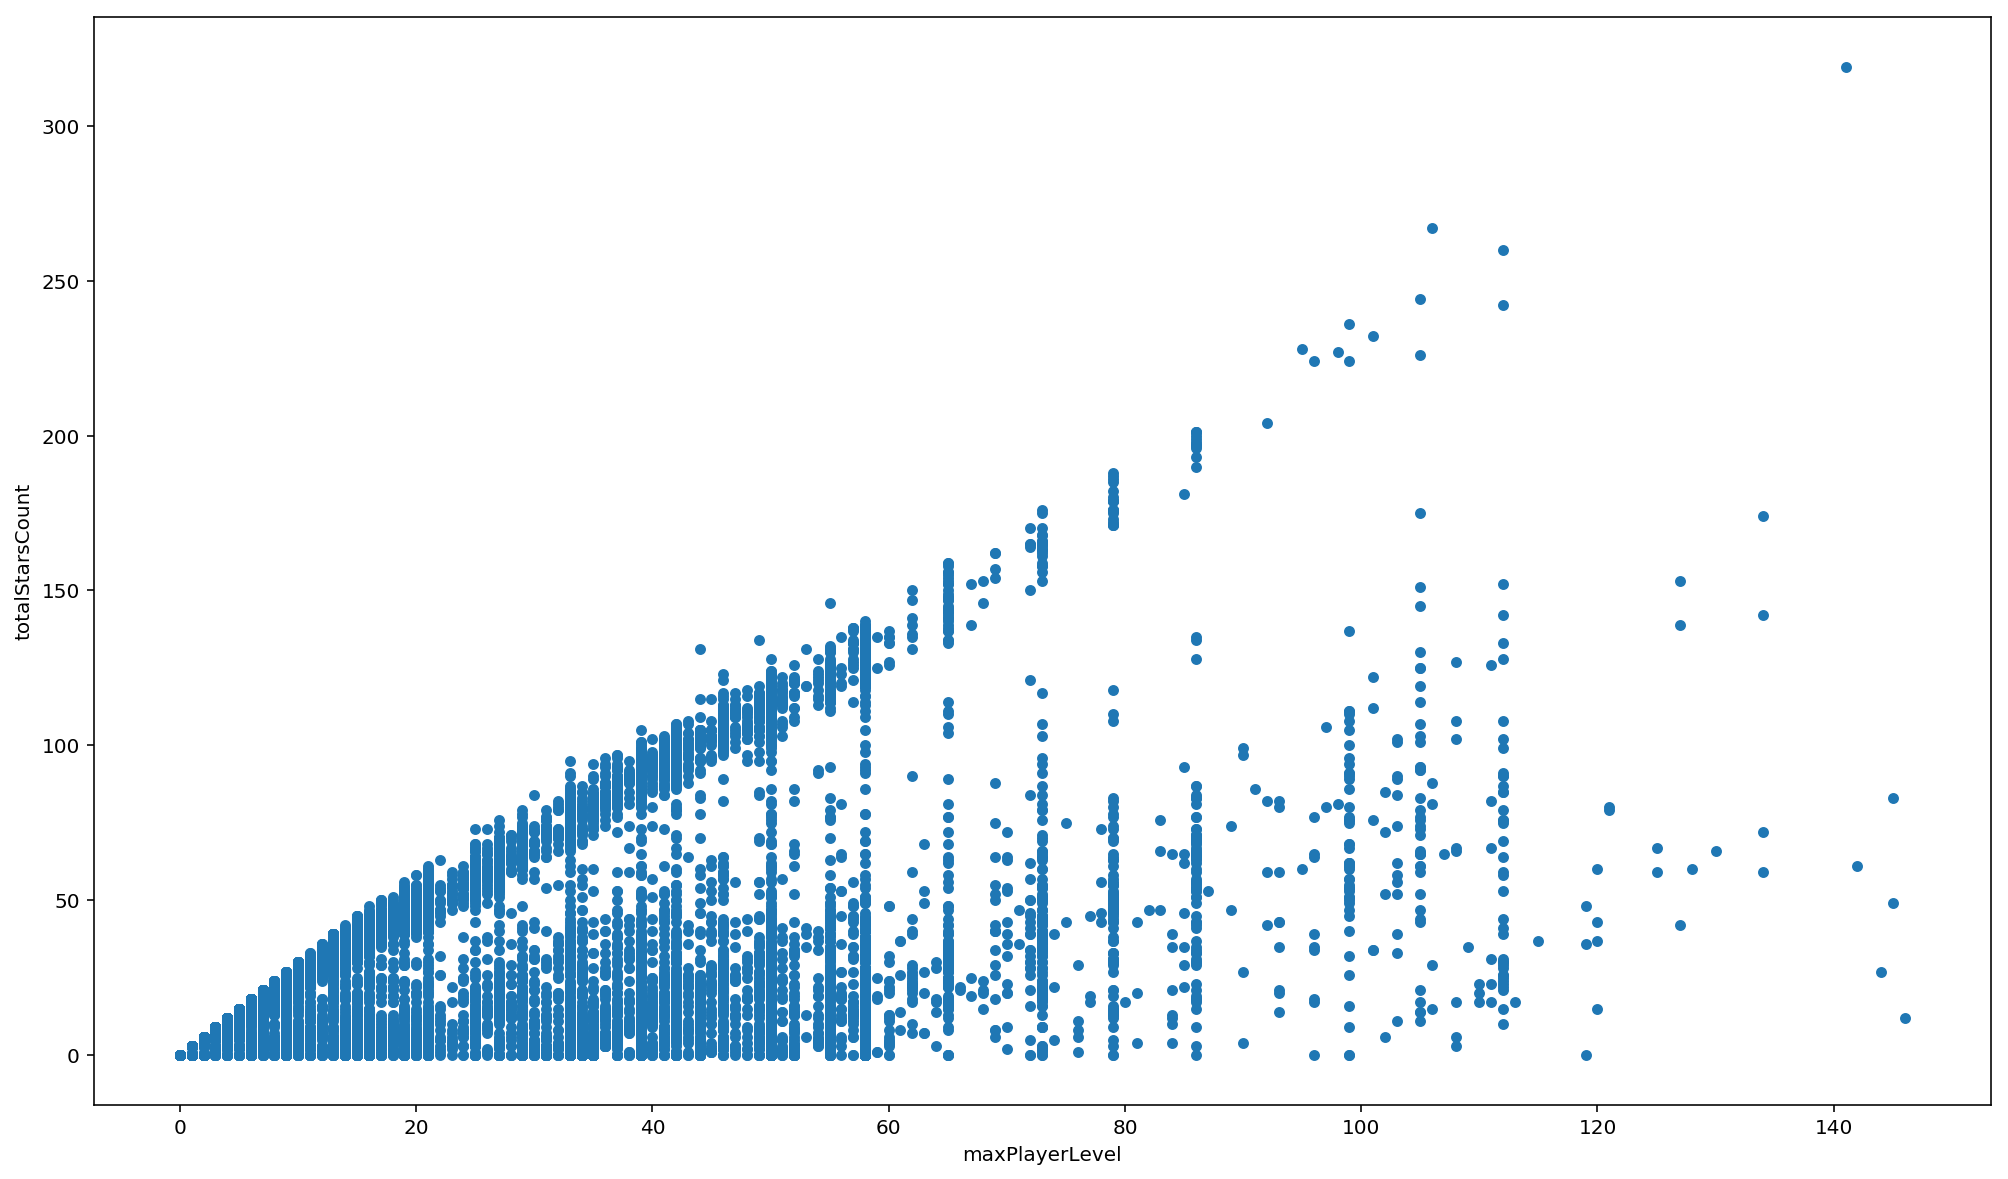

In [88]:
x_df[:samples].plot(x='maxPlayerLevel', y='totalStarsCount', kind='scatter', figsize=(17,10))

The player with more than 300 stars is definitely dislocated of trend.

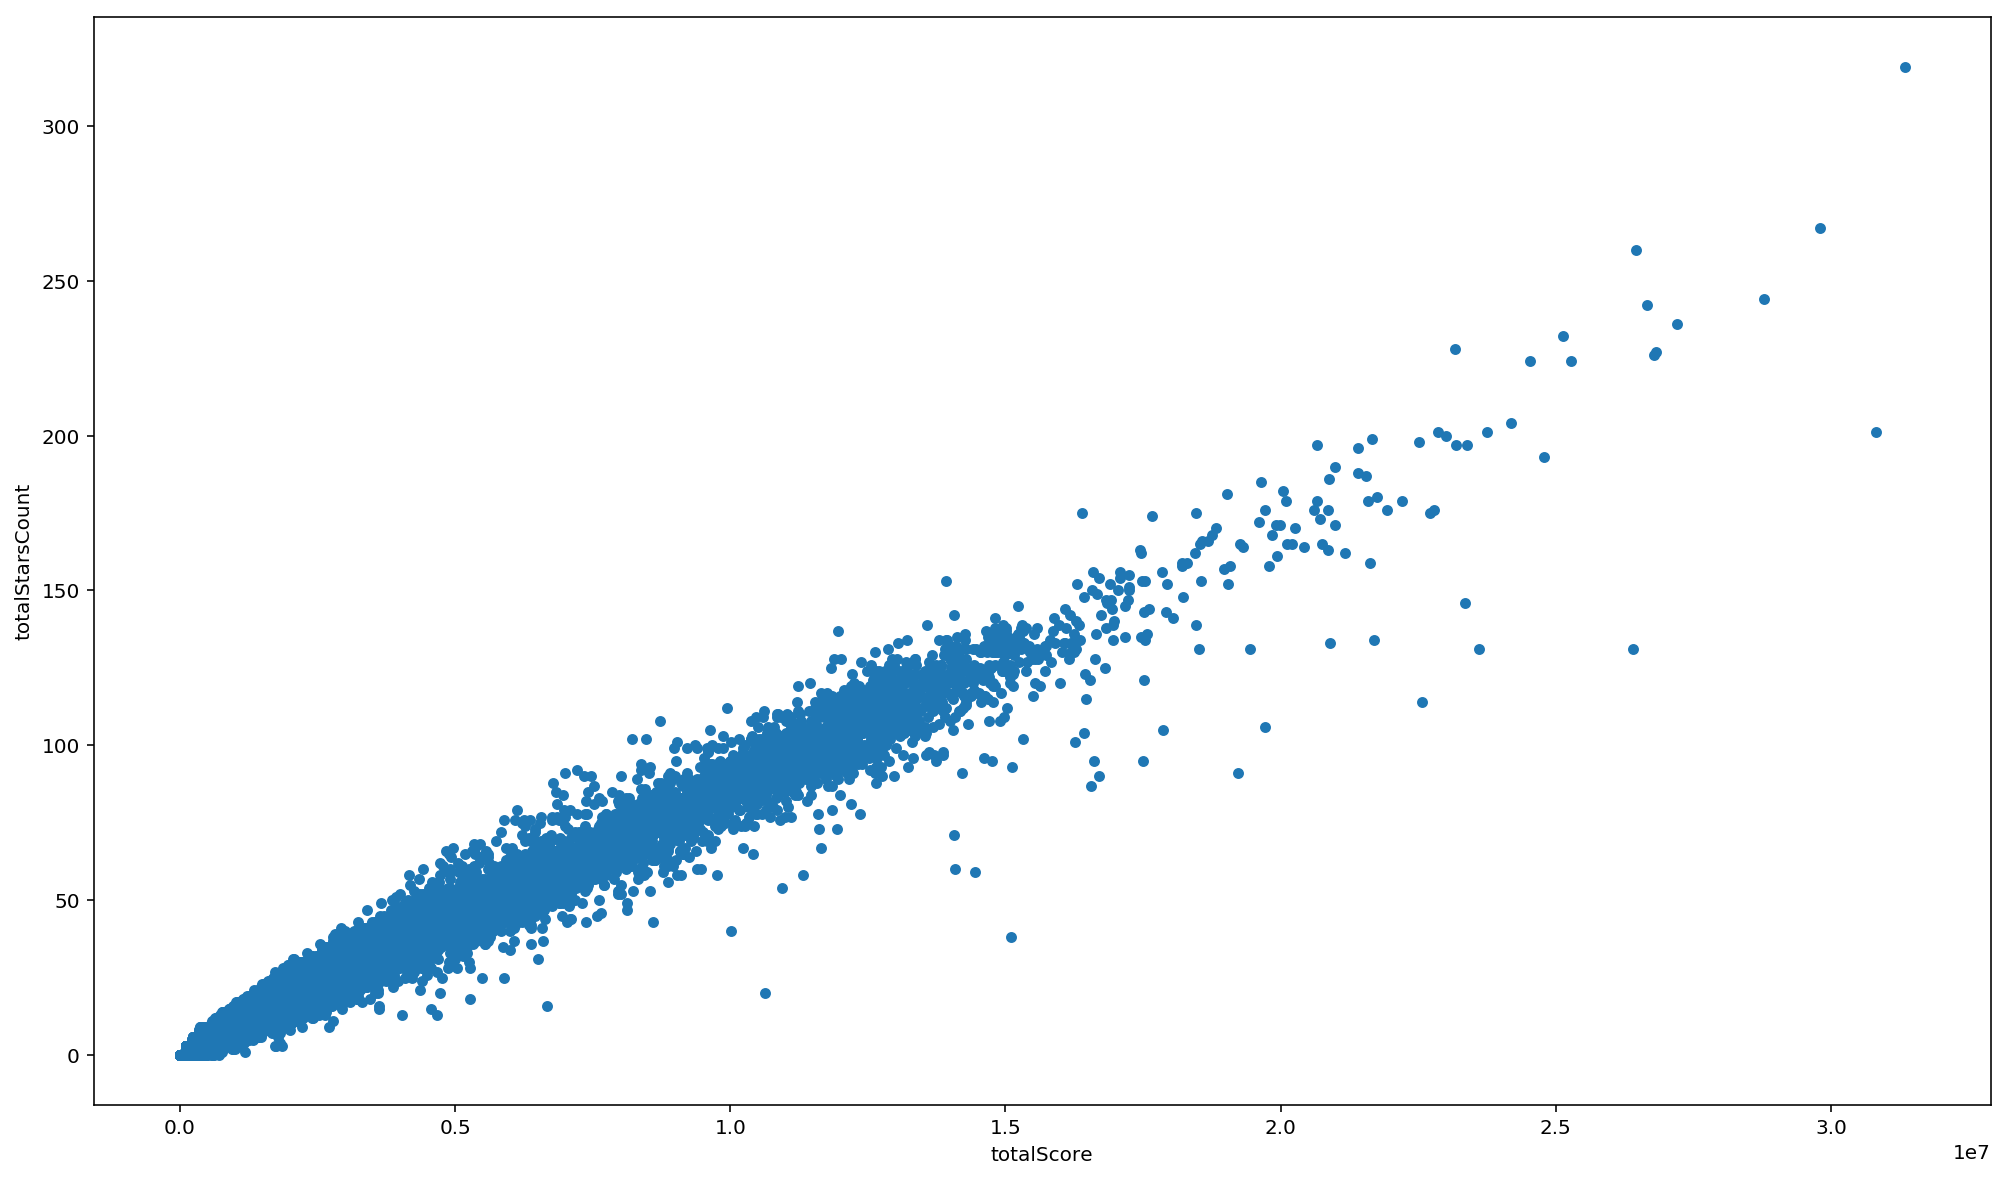

In [89]:
x_df[:samples].plot(x='totalScore', y='totalStarsCount', kind='scatter', figsize=(17,10))

He also has the biggest score and biggest bonus score (plot omitted).

Let's take a look on other numbers related to this player.

In [90]:
max_stars = x_df['totalStarsCount'].idxmax()
x_df.loc[[max_stars]].head()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,status
24008,141,142,1,259,22.034965,1,81,0.814815,31338000,24275,319,8,1


What is interesting, in test data we have pretty similar player with even more extreme numbers.

In [91]:
max_stars = x_test['totalStarsCount'].idxmax()
x_test.loc[[max_stars]].head()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
21711,144,145,1,252,22.70068,1,81,0.876543,34767000,26125,344,5


# Preprocess data

## Drop outliers

Note: just some data massage, no real gains here.

In [9]:
x_df_clean = x_df
x_df_clean = x_df_clean.drop(x_df_clean.index[[max_stars]])
print(np.shape(x_df_clean))

(25288, 13)


## Normalize

TODO: compare with batch normalization

In [64]:
def norm(x):
    max_x = max(x)
    min_x = min(x)
    return (x - min_x)/(max_x - min_x)

In [65]:
x_df_norm = x_df
x_df_norm['maxPlayerLevel'] = norm(x_df_norm['maxPlayerLevel'])
x_df_norm['numberOfAttemptedLevels'] = norm(x_df_norm['numberOfAttemptedLevels'])
x_df_norm['attemptsOnTheHighestLevel'] = norm(x_df_norm['attemptsOnTheHighestLevel'])
x_df_norm['totalNumOfAttempts'] = norm(x_df_norm['totalNumOfAttempts'])
x_df_norm['averageNumOfTurnsPerCompletedLevel'] = norm(x_df_norm['averageNumOfTurnsPerCompletedLevel'])
x_df_norm['numberOfBoostersUsed'] = norm(x_df_norm['numberOfBoostersUsed'])
x_df_norm['totalScore'] = norm(x_df_norm['totalScore'])
x_df_norm['totalBonusScore'] = norm(x_df_norm['totalBonusScore'])
x_df_norm['totalStarsCount'] = norm(x_df_norm['totalStarsCount'])
x_df_norm['numberOfDaysActuallyPlayed'] = norm(x_df_norm['numberOfDaysActuallyPlayed'])

In [92]:
x_df_norm.head(10)

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,status
0,0.267123,0.063830,0.010811,0.028470,0.611111,1,0.061728,0.400000,0.084562,0.056643,0.065831,0.076923,0
1,0.143836,0.148936,0.097297,0.096085,0.426136,1,0.074074,0.333333,0.179144,0.157570,0.159875,0.230769,1
2,0.034247,0.035461,0.000000,0.008897,0.210000,0,0.012346,1.000000,0.027347,0.047374,0.043887,0.000000,1
3,0.143836,0.007092,0.021622,0.008897,0.475000,0,0.012346,0.000000,0.003829,0.000000,0.003135,0.000000,1
4,0.027397,0.028369,0.000000,0.007117,0.240000,0,0.012346,1.000000,0.027347,0.044284,0.037618,0.000000,0
5,0.000000,0.000000,0.000000,0.000000,0.075000,0,0.000000,0.000000,0.003606,0.010299,0.000000,0.000000,0
6,0.089041,0.092199,0.005405,0.032028,0.387500,0,0.061728,0.800000,0.122248,0.118435,0.106583,0.076923,1
7,0.089041,0.092199,0.021622,0.044484,0.369231,0,0.049383,0.500000,0.110345,0.097837,0.097179,0.076923,1
8,0.013699,0.014184,0.000000,0.003559,0.191667,0,0.000000,0.000000,0.013402,0.030896,0.018809,0.000000,0
9,0.006849,0.007092,0.010811,0.007117,0.075000,1,0.000000,0.000000,0.003606,0.010299,0.009404,0.000000,0


## Split to cross validation and training data

## Create model

In [211]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.core import Activation, Dropout

def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(features*2, input_dim=features, init='normal'))
    model.add(Activation('elu'))
    
    model.add(Dense(512, init='normal'))
    model.add(Activation('elu'))
    
    model.add(Dense(128, init='normal'))
    model.add(Activation('elu'))
    
    #model.add(Dense(features*5, init='normal'))
    #model.add(Activation('elu'))
    
    model.add(Dense(1, init='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print('weigths: ', model.get_weights())
    return model

In [212]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

dsataset = x_df_norm.values
# split into input (X) and output (Y) variables
X = dsataset[:,0:features].astype(float)
Y = dsataset[:,features]

# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=200, batch_size=512, verbose=1)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [213]:
#results = cross_val_score(estimator, X, Y, cv=kfold)
#print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [214]:
estimator.fit(X, Y, verbose=1, validation_split=0.15, shuffle=True)

Train on 21495 samples, validate on 3794 samples
Epoch 1/200
21495/21495 [==============================] - 1s - loss: 0.5232 - acc: 0.7639 - val_loss: 0.4092 - val_acc: 0.8216
Epoch 2/200
21495/21495 [==============================] - 0s - loss: 0.4064 - acc: 0.8227 - val_loss: 0.3998 - val_acc: 0.8239

In [153]:
x_test_norm = x_test
x_test_norm['maxPlayerLevel'] = norm(x_test_norm['maxPlayerLevel'])
x_test_norm['numberOfAttemptedLevels'] = norm(x_test_norm['numberOfAttemptedLevels'])
x_test_norm['attemptsOnTheHighestLevel'] = norm(x_test_norm['attemptsOnTheHighestLevel'])
x_test_norm['totalNumOfAttempts'] = norm(x_test_norm['totalNumOfAttempts'])
x_test_norm['averageNumOfTurnsPerCompletedLevel'] = norm(x_test_norm['averageNumOfTurnsPerCompletedLevel'])
x_test_norm['numberOfBoostersUsed'] = norm(x_test_norm['numberOfBoostersUsed'])
x_test_norm['totalScore'] = norm(x_test_norm['totalScore'])
x_test_norm['totalBonusScore'] = norm(x_test_norm['totalBonusScore'])
x_test_norm['totalStarsCount'] = norm(x_test_norm['totalStarsCount'])
x_test_norm['numberOfDaysActuallyPlayed'] = norm(x_test_norm['numberOfDaysActuallyPlayed'])

In [154]:
x_test_norm.head()

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
0,0.090278,0.041667,0.002747,0.016701,0.375000,0,0.023256,1.0,0.045014,0.043062,0.046512,0.000000
1,0.020833,0.020833,0.000000,0.006263,0.166667,0,0.000000,0.0,0.017315,0.034450,0.026163,0.000000
2,0.291667,0.048611,0.005495,0.048017,0.514881,0,0.058140,0.4,0.063163,0.052632,0.049419,0.230769
3,0.270833,0.027778,0.008242,0.025052,0.546875,0,0.000000,0.0,0.038916,0.024880,0.023256,0.230769
4,0.041667,0.041667,0.000000,0.012526,0.235119,0,0.023256,1.0,0.038887,0.052632,0.046512,0.000000


In [155]:
test = x_test_norm.as_matrix()
preds = estimator.predict_proba(test)
print(preds)

13312/25289 [==============>...............] - ETA: 0s [[ 0.88229555  0.11770445]
 [ 0.9696359   0.03036408]
 [ 0.40878975  0.59121025]
 ..., 
 [ 0.95019144  0.04980855]
 [ 0.75608933  0.24391064]
 [ 0.98254389  0.01745611]]


In [156]:
pd.DataFrame(preds[:,1]).head()

,0
0,0.117704
1,0.030364
2,0.591210
3,0.551210
4,0.046046


In [158]:
proba = pd.DataFrame(preds[:,1])
fp = open('submission8.csv','w')
fp.write(proba.to_csv(header=False, index=False))

498244

# Results
Place: 417 out of 614